## Compare PCA weights spatially

In [1]:
'''
Dependencies
'''
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy
import pandas as pd
import scipy.stats as stats
import scipy.sparse as sparse
import warnings 
from scipy import integrate
import seaborn as sns
warnings.simplefilter('ignore')
from sklearn import decomposition
import scipy.io as sio
import os

sns.set_style('white')
# to change default color cycle
cs = ['#DC7253', '#264653', '#3DC1AB', '#92F0E4', '#CEE2DA', '#DC7253', '#4D7399', '#CDBCA5']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)
cmap = sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
import importlib
import rutils

%load_ext autoreload
%autoreload 2

from pyaldata import *
from rutils import *

## Load data

In [2]:
'''
Insert path and filename 
'''
path = '/Users/Daphne/Data/'  
fname = 'Chewie_CO_VR_2016-10-06.mat' 
df = mat2dataframe(path+fname, shift_idx_fields=True)

In [3]:
df.shape

(774, 24)

## 1 Preprocess 

### 1.1 Combine time bins

In [4]:
td = combine_time_bins(df, n_bins=3)

### 1.2 Remove low firing neurons

In [5]:
td = remove_low_firing_neurons(td, signal='M1_spikes', threshold=5)
td = remove_low_firing_neurons(td, signal='PMd_spikes', threshold=5)

### 1.3 Transform signals

In [6]:
td = transform_signal(td, signal='M1_spikes',  transformations='sqrt')
td = transform_signal(td, signal='PMd_spikes', transformations='sqrt')

### 1.4 Merge signals

In [7]:
td = merge_signals(td, ['M1_spikes', 'PMd_spikes'], 'both_spikes')

### 1.5 Compute firing rates from spike trains

Add firing rates for `M1_spikes`, `PMd_spikes` and `both_spikes`

In [8]:
# works on '_spikes' fields and automatically divides by bin_size
td = add_firing_rates(td, 'smooth')

### 1.6 Select data from Baseline epoch

Select only those rows from the baseline epoch `'BL'`

In [9]:
td = td.loc[df['epoch'] == 'BL']

In [10]:
td.shape

(217, 28)

## 2 Do Principal Component Analysis

### 2.1 Do PCA on both arrays 

`both_rates`

In [11]:
which_dim = 0 

m1pmd_weights = getPCA(rates=td['both_rates'])

w = m1pmd_weights[:, which_dim] 

This is the eigenvector associated with the first PC. 

Each element represents a loading, namely how much (the weight) each original neuron contributes to the corresponding principal component.

In [12]:
w.shape # total number of neurons

(143,)

### 2.2 Do PCA on PMd array

In [13]:
# TODO

### 2.3 Do PCA on all neurons combined

In [14]:
# TODO

## 3 Analyse PC weights 

> Does weight on first PC inversely correlate with distance

In [15]:
binz = np.arange(0, 0.5, 0.005)

### 3.1 Read in cmp files

In [16]:
df_m1_arr = read_cmp(file_path='/Users/Daphne/Desktop/Chewie Left M1 SN 6250-001474.cmp')
df_pmd_arr = read_cmp(file_path='/Users/Daphne/Desktop/Chewie Left PMd SN 6251-001469.cmp')

### 3.2 Create electrode maps

In [17]:
m1_elecmap  = localize_elecs(df_m1_arr, elecs=range(1,97))
pmd_elecmap = localize_elecs(df_pmd_arr, elecs=range(1,97))

### 3.3 Compare PC weights for M1

In [18]:
within_arr_dist, within_arr_w, between_arr_w = compare_pc_weights(main_arr=m1_elecmap, main_ug=td['M1_unit_guide'][0], w=w, other_ug=td['PMd_unit_guide'][0])

In [19]:
len(within_arr_dist)

946

In [20]:
other_dist = np.full(len(between_arr_w), np.nan)

In [21]:
df = pd.DataFrame({'distance': np.concatenate((within_arr_dist, other_dist), axis=0),  'w_diff': np.concatenate((within_arr_w, between_arr_w), axis=0)})

In [22]:
df['group'] = df['distance'].apply(lambda d: 'same elec' if d == 0 else ('same array' if d > 0 else 'other array'))

In [23]:
df # now we can use the 'group' colum to select the rows

,distance,w_diff,group
0,0.000000,0.043199,same elec
1,5.099020,0.206134,same array
2,5.099020,0.023563,same array
3,1.414214,0.084097,same array
4,1.414214,0.023512,same array
...,...,...,...
5297,NaN,0.395820,other array
5298,NaN,0.013173,other array
5299,NaN,0.019942,other array
5300,NaN,0.089246,other array


In [24]:
#plt.scatter(within_arr_dist, within_arr_w); #TODO make categories from here

In [25]:
same_elec = df.loc[df['group'] == 'same elec']['w_diff'].values
same_arr = df.loc[df['group'] == 'same array']['w_diff'].values
other_arr = df.loc[df['group'] == 'other array']['w_diff'].values

In [26]:
# normalise for histogram

# get the counts per bin
n_se, _ = np.histogram(same_elec, bins=binz)
n_se = n_se/max(n_se) # normalise

# get the counts per bin
n_sa, _ = np.histogram(same_arr, bins=binz)
n_sa = n_sa/max(n_sa) # normalise

# get the counts per bin
n_oa, _ = np.histogram(other_arr, bins=binz)
n_oa = n_oa/max(n_oa) # normalise

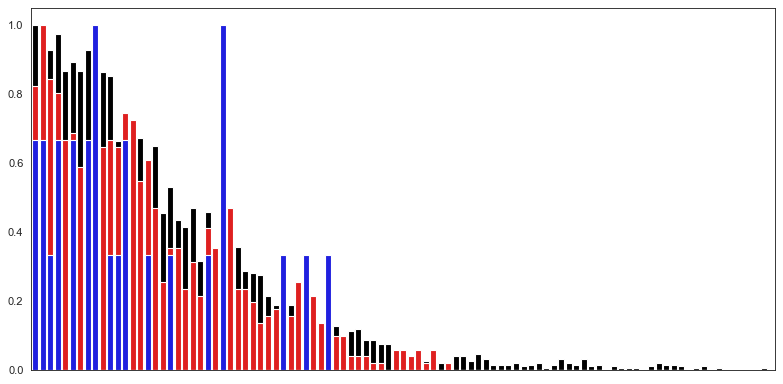

In [28]:
fig, ax = plt.subplots(1, figsize=(12, 6), dpi=80)
sns.barplot(x=binz[:-1], y=n_oa, color='k');
sns.barplot(x=binz[:-1], y=n_sa, color='r');
sns.barplot(x=binz[:-1], y=n_se, color='b');
plt.xticks([]);

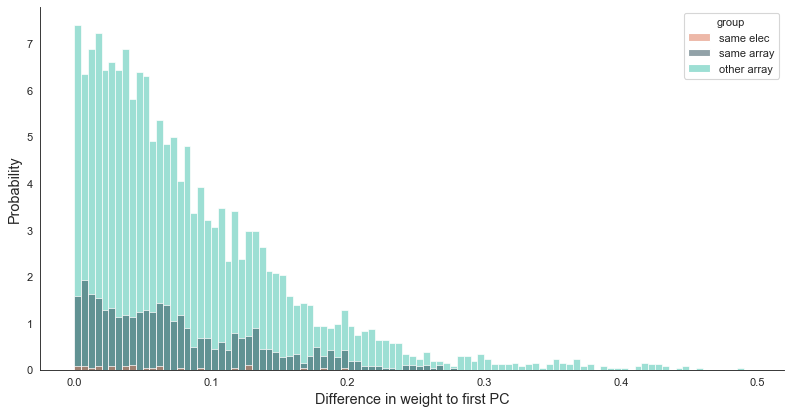

In [33]:
fig, ax = plt.subplots(1, figsize=(12, 6), dpi=80)

sns.histplot(df, x='w_diff', hue='group', bins=binz, stat='density')
ax.set_title('', fontsize=14)
ax.set_xlabel('Digit fference in weight to first PC', fontsize=13)
ax.set_ylabel('Probability', fontsize=13);
sns.despine()

In [30]:
# unit_guide = df['M1_unit_guide'][0]

# df_flat = pd.DataFrame(columns=['electrode', 'neuron', 'trial', 'spikes'])

# for i, row in enumerate(unit_guide):
#     e, n = row
#     df_app = pd.DataFrame(columns=['trial', 'spikes'])
#     for tr in range(df.shape[0]):
#         df_app = df_app.append({
#             'trial' : tr,
#             'spikes' : df['M1_spikes'][tr][:, i]
#         }, ignore_index=True)
#     df_app['electrode'] = e
#     df_app['neuron'] = n
#     df_flat = df_flat.append(df_app, ignore_index=True)
    
# df_flat = df_flat.loc[:, ['electrode', 'neuron', 'trial', 'spikes']]